In [109]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine
import torchinfo

In [110]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [111]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [112]:
# Get a set of pretrained model weights
weights = torchvision.models.VGG16_BN_Weights.DEFAULT
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [113]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [114]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=6)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2661af690a0>,
 ['high', 'low', 'medium'])

In [115]:
model = torchvision.models.vgg16_bn(weights=weights).to(device)

In [116]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [117]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(in_features=25088, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [118]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [119]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:17<01:10, 17.56s/it]

Epoch: 1 | train_loss: 1.1258 | train_acc: 0.4778 | test_loss: 0.7084 | test_acc: 0.7917


 40%|████      | 2/5 [00:35<00:53, 17.68s/it]

Epoch: 2 | train_loss: 0.3048 | train_acc: 0.8889 | test_loss: 0.5972 | test_acc: 0.7500


 60%|██████    | 3/5 [00:53<00:35, 17.74s/it]

Epoch: 3 | train_loss: 0.1023 | train_acc: 0.9556 | test_loss: 0.5327 | test_acc: 0.7500


 80%|████████  | 4/5 [01:11<00:17, 17.91s/it]

Epoch: 4 | train_loss: 0.1382 | train_acc: 0.9556 | test_loss: 0.5611 | test_acc: 0.7500


100%|██████████| 5/5 [01:29<00:00, 17.90s/it]

Epoch: 5 | train_loss: 0.0640 | train_acc: 0.9889 | test_loss: 0.5436 | test_acc: 0.8333
[INFO] Total training time: 89.507 seconds


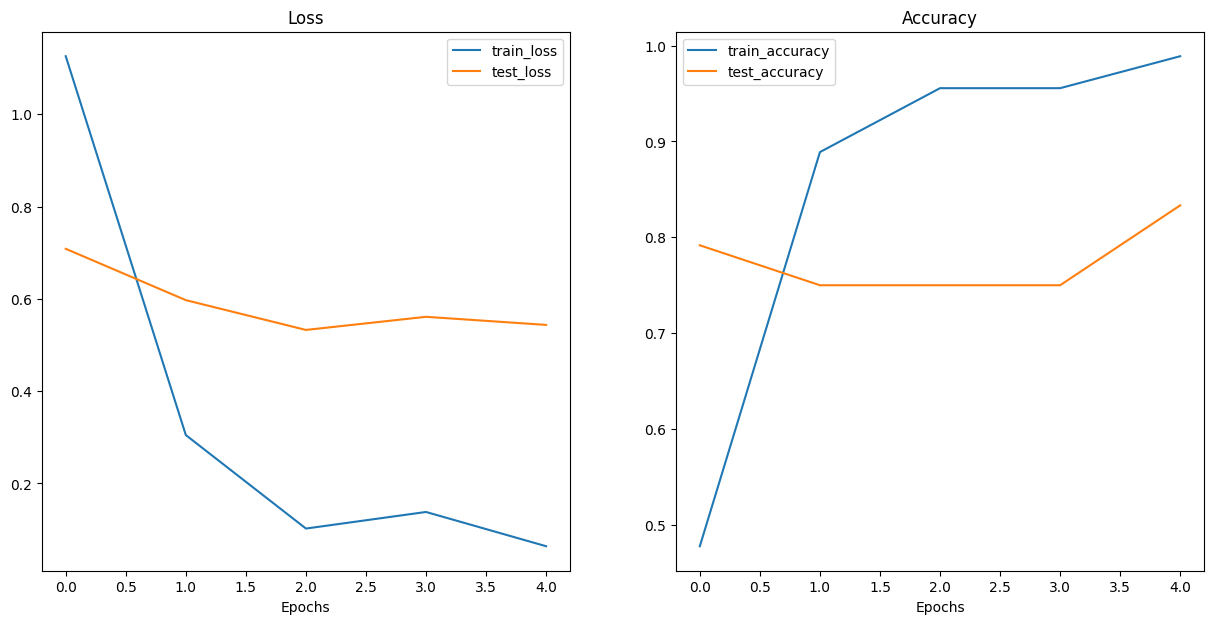

In [120]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)